# Import libraries and data

In [103]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hdbscan
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, AffinityPropagation
import ast 
from scipy.stats import mode
import random

# for dimensionality reduction
from umap.umap_ import UMAP
import umap
# for automating the 'knee method'
from kneed import KneeLocator
from sklearn.metrics import confusion_matrix, classification_report, silhouette_score

In [57]:
df =  pd. read_csv('../data/name_embeds_complete_no_context.csv',index_col=0)

In [58]:
df.head()

,name,price,category,embeddings
0,Alete Abendbrei Bio Keksbrei 190g,1.29,Babybedarf,"[-0.047637939453125, 0.006134033203125, 0.0454..."
1,Alete Abendmahlzeit zum Trinken Mehrkorn-Getre...,1.99,Babybedarf,"[-0.033355712890625, 0.0202789306640625, 0.022..."
2,Alete Bio Apfel-Pfirsich mit Keks nach 4. Mona...,1.29,Babybedarf,"[-0.05810546875, 0.0166778564453125, 0.0557556..."
3,Alete Bio Banane-Apfel mit Vollkorn-Getreide 190g,1.29,Babybedarf,"[-0.0217742919921875, 0.0098724365234375, 0.04..."
4,Alete Bio Erbseneintopf 250g,1.59,Babybedarf,"[-0.03509521484375, 0.01074981689453125, 0.061..."


In [8]:
embeddings = df.embeddings.tolist()
embeddings_list = [ast.literal_eval(s) for s in embeddings]
X = np.array(embeddings_list) 

In [9]:
X.shape

(19121, 1024)

In [10]:
dmeasure = 'euclidean' # distance metric
rdims = 2 # r-dims == Reduced dimensionality
print(f"UMAP dimensionality reduction to {rdims} dimensions with '{dmeasure}' distance measure.")

UMAP dimensionality reduction to 2 dimensions with 'euclidean' distance measure.


In [11]:
# Create and apply a UMAP 'reducer'
reducer = umap.UMAP(n_neighbors=25, min_dist=0.01,n_components=rdims,random_state=42)

X_embedded = reducer.fit_transform(X)

# Create a dictionary that is easily converted into a pandas df
embedded_dict = {}
for i in range(0, X_embedded.shape[1]):
    embedded_dict[f"Dim{i+1}"] = X_embedded[:,i] # D{dimension_num} (Dim 1, ..., Dim n)

dfe = pd.DataFrame(embedded_dict, index = df.index)
del(embedded_dict)

/Users/jakob/Documents/neue_fische/creamCheese-LTJ/.venv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [12]:
df.shape[0]

19121

In [13]:
dfe.head()

,Dim1,Dim2
0,14.883826,2.203474
1,10.445395,3.418953
2,14.946111,2.149840
3,14.983174,2.118955
4,14.886119,2.020024


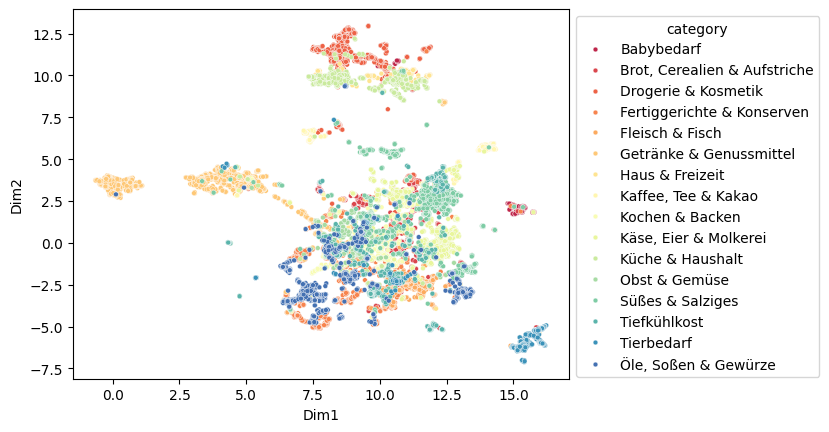

In [14]:
ax = sns.scatterplot(data = dfe, x='Dim1',y='Dim2', hue=df.category,s=12,palette='Spectral')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))


In [15]:
kmeans = KMeans(n_clusters = 16, random_state=42)
clusters = kmeans.fit_predict(dfe)

# true lables
true_labels = df.category.unique().tolist()
df['category_num'] = df.category.astype('category').cat.codes
true_labels_num = df.category_num.unique().tolist()

'''# Permute the labels
labels = np.zeros_like(clusters)
for i in range(16):
    mask = (clusters == i)
    labels[mask] = mode(true_labels_num[mask])[0]


# Plot the confusion matrix
mat = confusion_matrix(true_labels, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');'''


/Users/jakob/Documents/neue_fische/creamCheese-LTJ/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


"# Permute the labels\nlabels = np.zeros_like(clusters)\nfor i in range(16):\n    mask = (clusters == i)\n    labels[mask] = mode(true_labels_num[mask])[0]\n\n\n# Plot the confusion matrix\nmat = confusion_matrix(true_labels, labels)\nsns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,\n            xticklabels=digits.target_names,\n            yticklabels=digits.target_names)\nplt.xlabel('true label')\nplt.ylabel('predicted label');"

In [16]:
dfe['clusters'] = clusters

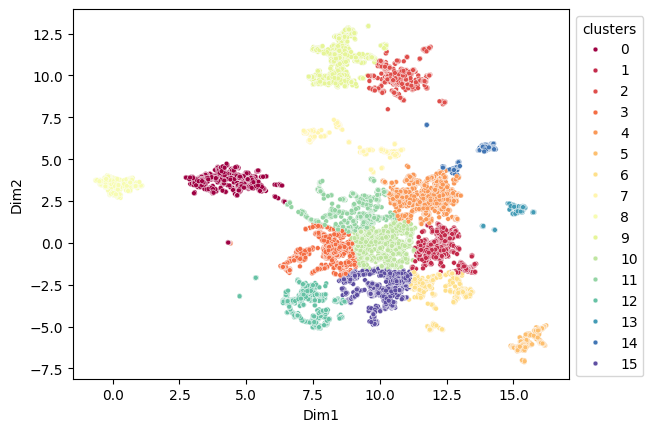

In [17]:
ax = sns.scatterplot(data = dfe, x='Dim1',y='Dim2', hue=dfe.clusters,s=12, legend='full',palette='Spectral')
sns.move_legend(ax, 'upper left', bbox_to_anchor=(1, 1))

In [18]:
kmeans_maxed = KMeans(n_clusters = 16, random_state=42)
clusters = kmeans.fit_predict(X)

/Users/jakob/Documents/neue_fische/creamCheese-LTJ/.venv/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### Try to generate clusters without labels from embeddings using UMAP+HDBSCAN

Based on the article: [Clustering sentence embeddings to identifiy intents in short text](https://towardsdatascience.com/clustering-sentence-embeddings-to-identify-intents-in-short-text-48d22d3bf02e).

Our embeddings have high dimensionality (1024 features), so as a manifestation of the "Curse of Dimensionality" the commonly applied distance measures like Euclidean and Manhattan become meaningless in this high dimensional feature space (see [here](https://bib.dbvis.de/uploadedFiles/155.pdf)). Therefore, we need do reduce the dimensionality before clustering. Uniform Manifold Approximation and Projection (UMAP) is apparently faster, more scalable and better suited for preserving the global structure of the data than for example t-SNE. --> Go for UMAP.

For the clustering we need an algorithm that does not require a specific number of expected clusters as input and that can tolerate noisy data. One suitable option would be DBSCAN. However, there is another version called HDBSCAN (H for hierarchical), which is more robust with respect to clusters with varying density.

The challenge is to find suitable hyperparameters for both dimensionality reduction and clustering in order to produce meaningful clusters in the end. The most important are `n_components` and `n_neighbors`. The first controls the output dimensionality of the embeddings after dimensionality reduction and the latter controlls how UMAP balances between the local and the global structure in the data. For the `min_cluter_size`we can something on the order of our smalles actual cluster (which consists of 277 products). 

In [19]:
def generate_clusters(input_embeddings, n_neighbors, n_components, min_cluster_size, random_state = None):
    '''
    Generate HDBSCAN cluster object after reducing embedding dimensionality with UMAP
    '''

    umap_embeddings = (umap.UMAP(n_neighbors=n_neighbors,
                                n_components=n_components,
                                metric='cosine', 
                                random_state=random_state).fit_transform(input_embeddings))
    
    clusters = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,
                               metric='euclidean',
                               cluster_selection_method='eom').fit(umap_embeddings)
    return clusters

In [21]:
def score_clusters(clusters, prob_threshold = 0.05):
    '''
    Returns the label count and cost of a given cluster supplied from running hdbscan
    '''    

    cluster_labels = clusters.labels_
    label_count = len(np.unique(cluster_labels))
    total_num = len(clusters.labels_)
    cost = (np.count_nonzero(clusters.probabilities_ < prob_threshold/total_num))

    return label_count, cost

In [32]:
def random_search(embeddings, space, num_evals):
    '''
    Randomly search hyperparameter space and limited number of times and return a summary of the results
    '''

    results = []

    for i in range(num_evals):
        n_neighbors = random.choice(space['n_neighbors'])
        n_components = random.choice(space['n_components'])
        min_cluster_size = random.choice(space['min_cluster_size'])

        clusters = generate_clusters(embeddings, n_neighbors=n_neighbors,
                                     n_components=n_components,
                                     min_cluster_size=min_cluster_size) #, random_state=42)
        
        label_count, cost = score_clusters(clusters, prob_threshold = 0.05)

        results.append([i, n_neighbors, n_components, min_cluster_size, label_count, cost])

    result_df = pd.DataFrame(results, columns=['run_id',
                                               'n_neighbors',
                                               'n_components',
                                               'min_cluster_size',
                                               'label_count',
                                               'cost'])
    
    return result_df.sort_values(by='cost')

In [44]:
space = {
    "n_neighbors": range(25,60),
    "n_components": range (8,16),
    "min_cluster_size": range(180,300),
    #"random_state": 42
}

random_use = random_search(X,space,100)

In [31]:
df.category.value_counts()

category
Getränke & Genussmittel         2626
Süßes & Salziges                2041
Fertiggerichte & Konserven      2035
Drogerie & Kosmetik             1759
Käse, Eier & Molkerei           1508
Öle, Soßen & Gewürze            1422
Brot, Cerealien & Aufstriche    1352
Kochen & Backen                 1073
Küche & Haushalt                1058
Fleisch & Fisch                  929
Tiefkühlkost                     903
Tierbedarf                       718
Kaffee, Tee & Kakao              663
Babybedarf                       405
Haus & Freizeit                  352
Obst & Gemüse                    277
Name: count, dtype: int64

In [47]:
random_use.tail(50)

,run_id,n_neighbors,n_components,min_cluster_size,label_count,cost
15,15,56,13,285,7,2373
63,63,29,10,214,16,6145
13,13,25,12,202,17,6177
18,18,32,15,185,19,6304
76,76,50,10,200,19,6304
94,94,55,15,192,20,6312
6,6,30,12,184,19,6329
31,31,58,9,235,16,6472
49,49,54,8,206,16,6485
44,44,52,8,203,19,6487


In [95]:
# build the model for run 63 to have a detailed look on the clusters

reduced_embeddings = umap.UMAP(n_neighbors=57,
                              n_components=10,
                              metric='cosine').fit_transform(X)
    
unsup_clusters = hdbscan.HDBSCAN(min_cluster_size=180,
                                metric='euclidean',
                                cluster_selection_method='eom').fit(reduced_embeddings)

In [96]:
score_clusters(unsup_clusters, prob_threshold = 0.05)

(21, 6765)

In [97]:
df['unsupervised_labels'] = unsup_clusters.labels_

In [98]:
df['category'] = pd.Categorical(df.category)
df['num_category'] = df.category.cat.codes

In [99]:
df.head(40)

,name,price,category,unsupervised_labels,num_category
0,Alete Abendbrei Bio Keksbrei 190g,1.29,Babybedarf,7,0
1,Alete Abendmahlzeit zum Trinken Mehrkorn-Getre...,1.99,Babybedarf,-1,0
2,Alete Bio Apfel-Pfirsich mit Keks nach 4. Mona...,1.29,Babybedarf,7,0
3,Alete Bio Banane-Apfel mit Vollkorn-Getreide 190g,1.29,Babybedarf,7,0
4,Alete Bio Erbseneintopf 250g,1.59,Babybedarf,15,0
5,Alete Buntes Bio Kartoffelgemüse mit Hühnchen ...,1.59,Babybedarf,7,0
6,Alete Grießbrei Vanille ab 10. Monat 400g,1.79,Babybedarf,-1,0
7,Alete Kinderkeks 180g,1.99,Babybedarf,-1,0
8,Alete Mahlzeit zum Trinken Keks 2x200ml,1.99,Babybedarf,-1,0
9,Alete Mahlzeit zum Trinken Schokolade 2x200ml,1.99,Babybedarf,-1,0


In [100]:
df.unsupervised_labels.unique()

array([ 7, -1, 15,  2,  1, 19, 17, 16, 18,  4,  8, 14,  3, 10, 11, 12, 13,
        0,  9,  5,  6])

In [101]:
#df.drop('embeddings',axis=1,inplace = True)

In [102]:
df.to_csv('../data/products_unsupervised_clusters.csv')